In [155]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [156]:
url = "https://prices.runescape.wiki/api/v1/osrs/timeseries?timestep=24h&id=20997"
headers = {
    "User-Agent": "Timeseries Data Science Coding Project (Limited Use)"
}
response = requests.get(url, headers=headers)

In [157]:
# Check the response status
if response.status_code == 200:
    data = response.json()
    print("Data received:")
else:
    print(f"Request failed with status code {response.status_code}")
    print(response.text)

Data received:


In [158]:
full_item_df = pd.json_normalize(data['data'])

In [159]:
full_item_df['timestamp'] = pd.to_datetime(full_item_df['timestamp'], unit='s', utc=True)
full_item_df['date'] = full_item_df['timestamp'].dt.date

In [160]:
item_df = full_item_df[['date', 'avgHighPrice']]
item_df['date'] = pd.to_datetime(item_df['date'])
item_df.set_index('date', inplace=True)
item_df.head()

<ipython-input-160-431340b488f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_df['date'] = pd.to_datetime(item_df['date'])


,avgHighPrice
date,
2024-09-16,1679143838
2024-09-17,1681469123
2024-09-18,1681638205
2024-09-19,1689078873
2024-09-20,1692751347


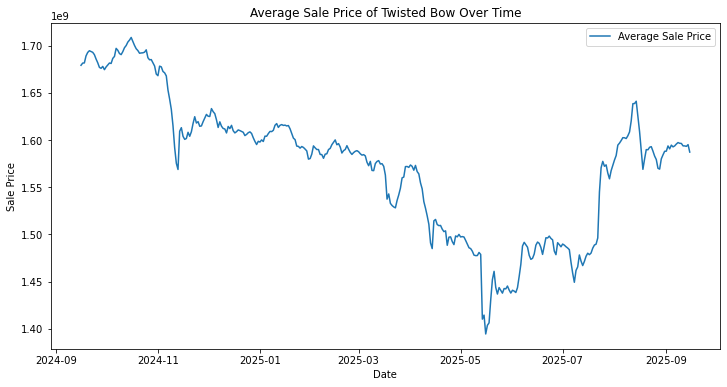

In [161]:
plt.figure(figsize=(12, 6))
plt.plot(item_df['avgHighPrice'], label='Average Sale Price')
plt.title('Average Sale Price of Twisted Bow Over Time')
plt.xlabel('Date')
plt.ylabel('Sale Price')
plt.legend()
plt.show()

In [162]:
item_df_train = item_df.iloc[:-90]
item_df_test = item_df.iloc[-90:]

print(item_df_train.size)
print(item_df_test.size)

275
90


# Best Model

In [163]:
model = auto_arima(
    item_df_train['avgHighPrice'],
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9493.817, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9486.648, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9488.448, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9488.339, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9486.713, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9490.239, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.366 seconds


# Non-Stationary Model

In [164]:
model = SARIMAX(item_df_train['avgHighPrice'], order=(0, 1, 0))
results = model.fit()

c:\Users\bmsuc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bmsuc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [165]:
forecast = results.get_forecast(steps=90)
forecast_values = forecast.predicted_mean
forecast_values.index = item_df_test.index
forecast_values.head()

date
2025-06-18    1.490428e+09
2025-06-19    1.490428e+09
2025-06-20    1.490428e+09
2025-06-21    1.490428e+09
2025-06-22    1.490428e+09
Name: predicted_mean, dtype: float64

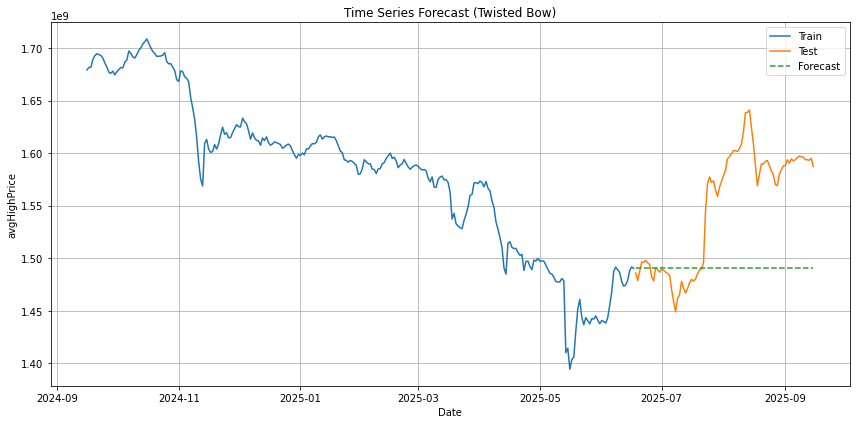

In [166]:
plt.figure(figsize=(12,6))
plt.plot(item_df_train.index, item_df_train['avgHighPrice'], label='Train')
plt.plot(item_df_test.index, item_df_test['avgHighPrice'], label='Test')
plt.plot(forecast_values.index, forecast_values, label='Forecast', linestyle='--')
plt.title('Time Series Forecast (Twisted Bow)')
plt.xlabel('Date')
plt.ylabel('avgHighPrice')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Stationary Model

In [167]:
model = SARIMAX(item_df_train['avgHighPrice'], order=(1, 0, 0))
results = model.fit()

c:\Users\bmsuc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bmsuc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [168]:
forecast = results.get_forecast(steps=90)
forecast_values = forecast.predicted_mean
forecast_values.index = item_df_test.index
forecast_values.head()

date
2025-06-18    1.490403e+09
2025-06-19    1.490379e+09
2025-06-20    1.490355e+09
2025-06-21    1.490330e+09
2025-06-22    1.490306e+09
Name: predicted_mean, dtype: float64

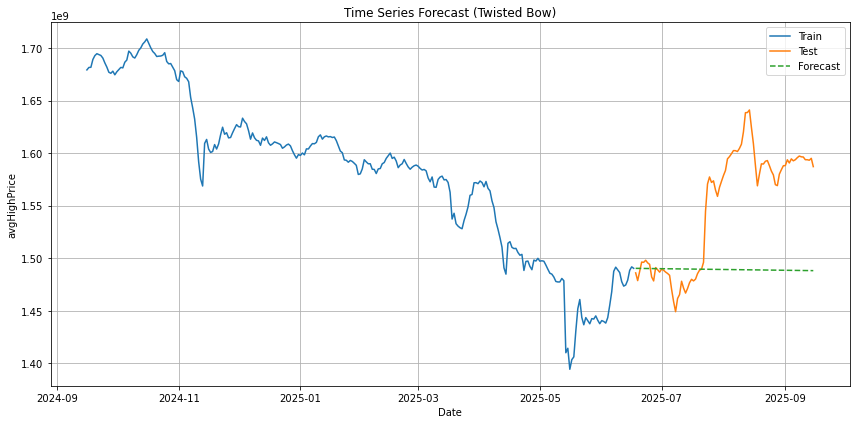

In [169]:
plt.figure(figsize=(12,6))
plt.plot(item_df_train.index, item_df_train['avgHighPrice'], label='Train')
plt.plot(item_df_test.index, item_df_test['avgHighPrice'], label='Test')
plt.plot(forecast_values.index, forecast_values, label='Forecast', linestyle='--')
plt.title('Time Series Forecast (Twisted Bow)')
plt.xlabel('Date')
plt.ylabel('avgHighPrice')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Seasonal Model

In [170]:
model = SARIMAX(item_df_train['avgHighPrice'], order=(0, 1, 0), seasonal_order=(1, 1, 1, 7))
results = model.fit()

c:\Users\bmsuc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bmsuc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [171]:
forecast = results.get_forecast(steps=90)
forecast_values = forecast.predicted_mean
forecast_values.index = item_df_test.index
forecast_values.head()

date
2025-06-18    1.482367e+09
2025-06-19    1.478472e+09
2025-06-20    1.479415e+09
2025-06-21    1.483649e+09
2025-06-22    1.492109e+09
Name: predicted_mean, dtype: float64

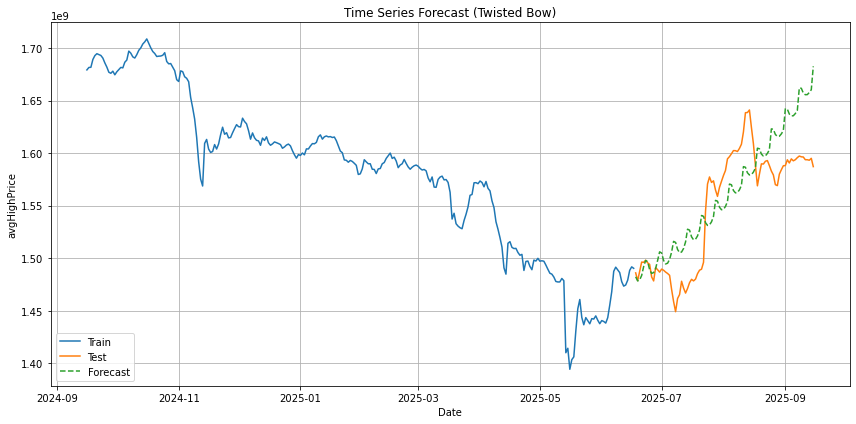

In [172]:
plt.figure(figsize=(12,6))
plt.plot(item_df_train.index, item_df_train['avgHighPrice'], label='Train')
plt.plot(item_df_test.index, item_df_test['avgHighPrice'], label='Test')
plt.plot(forecast_values.index, forecast_values, label='Forecast', linestyle='--')
plt.title('Time Series Forecast (Twisted Bow)')
plt.xlabel('Date')
plt.ylabel('avgHighPrice')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Extreme Model

In [173]:
model = SARIMAX(item_df_train['avgHighPrice'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 31))
results = model.fit()

c:\Users\bmsuc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bmsuc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bmsuc\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [174]:
forecast = results.get_forecast(steps=90)
forecast_values = forecast.predicted_mean
forecast_values.index = item_df_test.index
forecast_values.head()

date
2025-06-18    1.394764e+09
2025-06-19    1.409743e+09
2025-06-20    1.426864e+09
2025-06-21    1.432155e+09
2025-06-22    1.419260e+09
Name: predicted_mean, dtype: float64

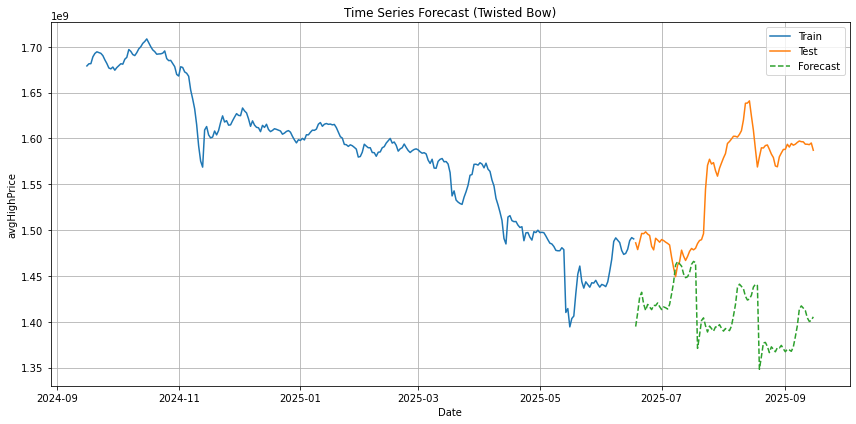

In [175]:
plt.figure(figsize=(12,6))
plt.plot(item_df_train.index, item_df_train['avgHighPrice'], label='Train')
plt.plot(item_df_test.index, item_df_test['avgHighPrice'], label='Test')
plt.plot(forecast_values.index, forecast_values, label='Forecast', linestyle='--')
plt.title('Time Series Forecast (Twisted Bow)')
plt.xlabel('Date')
plt.ylabel('avgHighPrice')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()